Mental Health and the Tech Industry
----------
#### Research Question
Can we predicting if an individual has sought treatment for a mental health condition based on a variety of mental health realted survey responses

Data from Kaggle: https://www.kaggle.com/osmi/mental-health-in-tech-survey

Imports 
-----

In [46]:
import numpy as np
import pandas as pd
from   category_encoders       import *

from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.compose         import TransformedTargetRegressor 
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from   sklearn.preprocessing   import LabelEncoder
from   sklearn.preprocessing   import StandardScaler
from   sklearn.base            import BaseEstimator
from   sklearn.ensemble        import RandomForestClassifier
from   sklearn.linear_model    import LogisticRegression 
from   sklearn.linear_model    import RidgeClassifier
from   sklearn.model_selection import RandomizedSearchCV
from   sklearn.model_selection import train_test_split
from   sklearn.neighbors       import KNeighborsClassifier
from   sklearn.svm             import SVC
from   sklearn.model_selection import cross_validate
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import f1_score
from   sklearn.metrics         import roc_auc_score
from   sklearn.metrics         import roc_curve
from   sklearn.inspection      import permutation_importance

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.filterwarnings("ignore")

Load Data
----

In [2]:
path = 'survey.csv'
df = pd.read_csv(path)

Squestering Test Set
----

In [3]:
y = df['treatment']
X = df.drop(columns=['treatment'])

X_train_main, X_test, y_train_main, y_test = train_test_split(X, y, random_state = 25)

Converting Target Variable 
----
Transforming the target variable y (has or has not sought treatment) from "yes" or "no" to 0 or 1 

In [5]:
le = LabelEncoder()
le.fit(y_train_main)

y_train_main = le.transform(y_train_main)
y_test = le.transform(y_test)

Building the Preprocessing Pipeline 
----

In [168]:
# categorical pipeline
bin_column = ['Age']
categorical_columns = ['Gender', 'Country', 'state', 'self_employed',
       'family_history', 'work_interfere', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical']

# binning age 
bin_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('bin', KBinsDiscretizer(n_bins=7, encode='onehot'))])

# categorical pipeline 
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

# combining preprocessing steps into one 
preprocessing = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('bin', bin_pipe, bin_column)])


Evaluation Metrics 
----
I selected the F1 measure as my first evaluation metric. I choose the F1 score because it balances precision and recall for the binary classification, which I feel is appropriate because I do not wish to prioritize precision or recall over the other. Furthermore it's values are always between 0 and 1 with values closer to 1 being better, which I feel is a simple and easy to interpret measure of this model. 

The second metric I track is the ROC score, or area under the Reciever Operating Characteristic curve. I chose this metric because it also captures a balance between precision and recall - prioritizing both a high true positive rate and a low false positive rate.  


Randomized CV Search to select candidate models
----

In [8]:
# helper class
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [9]:
algorithms = [RandomForestClassifier(),
             LogisticRegression(),
             RidgeClassifier(),
             KNeighborsClassifier(),
             SVC()]

for algo in algorithms: 
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('classifier',  algo)])
    f1_list = []
    roc_list = []
    
    for x in range(20):
        X_train, X_validate, y_train, y_validate = train_test_split(X_train_main, y_train_main)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_validate)
        f1 = f1_score(y_validate, y_pred)
        f1_list.append(f1)
        
        roc = roc_auc_score(y_validate, y_pred)
        roc_list.append(roc)
    
    average_f1 = sum(f1_list)/len(f1_list)
    average_roc = sum(roc_list)/len(roc_list)
        
    print(f"{algo.__class__.__name__:<17} - f1: {average_f1:,.2f}, roc: {average_roc:,.2f}")

RandomForestClassifier - f1: 0.84, roc: 0.83
LogisticRegression - f1: 0.84, roc: 0.83
RidgeClassifier   - f1: 0.85, roc: 0.83
KNeighborsClassifier - f1: 0.72, roc: 0.73
SVC               - f1: 0.86, roc: 0.84


Candidate 1: SVC
----

In [11]:
hyperparameters = {'classifier__C': [1.0,2,3,4,5],
                     'classifier__break_ties': [False, True],
                     'classifier__cache_size': [200],
                     'classifier__class_weight': [None],
                     'classifier__coef0': [0.0],
                     'classifier__decision_function_shape': ['ovr'],
                     'classifier__degree': [3,4,5,6,7],
                     'classifier__kernel': ['rbf','linear', 'poly', 'sigmoid', 'precomputed'],
                     'classifier__probability': [False, True],
                     'classifier__shrinking': [True, False],
                     'classifier__tol': [0.001, 0.01, 0.002, 0.01],
                     'classifier__verbose': [False]}

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  SVC())])


clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=hyperparameters, 
                              n_iter=25,
                              cv=5, 
                              n_jobs=-1,
                              verbose=False)

best_model_svc = clf_rand_cv.fit(X_train_main, y_train_main) 

In [12]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_svc, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std())

f1 scores with 0.85 accuracy with a standard deviation of 0.02
ROC scores with 0.88 accuracy with a standard deviation of 0.02


Candidate 2: RidgeClassifier
---

In [14]:
hyperparameters = {'classifier__alpha': [1.0, 2,3,4,5],
                    'classifier__class_weight': [None, 'balanced'],
                    'classifier__copy_X': [True, False],
                    'classifier__normalize': [False, True],
                    'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  RidgeClassifier())])


clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=hyperparameters, 
                              n_iter=25,
                              cv=5, 
                              n_jobs=-1,
                              verbose=False)

best_model_ridge = clf_rand_cv.fit(X_train_main, y_train_main) 

In [15]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_ridge, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std())

f1 scores with 0.85 accuracy with a standard deviation of 0.02
ROC scores with 0.89 accuracy with a standard deviation of 0.02


Candidate 3: Random Forest Classifier
----

In [17]:
hyperparameters = {'classifier__bootstrap': [True, False],
     'classifier__ccp_alpha': [1.0, 2.0, 0.0],
     'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
     'classifier__criterion': ['gini', 'entropy'],
     'classifier__max_depth': [None,2,3,4,5],
     'classifier__max_features': ['auto'],
     'classifier__max_leaf_nodes':[None, 2,3,4,5],
     'classifier__max_samples': [None,2,3,4,5],
     'classifier__min_impurity_decrease': [0.0],
     'classifier__min_impurity_split': [None],
     'classifier__min_samples_leaf': [1,2,3,4,5],
     'classifier__min_samples_split': [2,3,4,5,6],
     'classifier__min_weight_fraction_leaf': [0.0],
     'classifier__n_estimators': [10, 50, 100, 110, 120, 200],
     'classifier__oob_score': [False, True],
     'classifier__warm_start': [False, True]}

pipe = Pipeline([('preprocessing', preprocessing), 
                 ('classifier',  RandomForestClassifier())])


clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=hyperparameters, 
                              n_iter=25,
                              cv=5, 
                              n_jobs=-1,
                              verbose=False)

best_model_rf = clf_rand_cv.fit(X_train_main, y_train_main) 

In [18]:
scoring = ['f1', 'roc_auc']
scores = cross_validate(best_model_rf, X_train_main, y_train_main, cv=5, scoring=scoring)

f1_scores = scores['test_f1']
roc_auc_scores = scores['test_roc_auc']
print("f1 scores %0.2f with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
print("ROC scores %0.2f with a standard deviation of %0.2f" % (roc_auc_scores.mean(), roc_auc_scores.std())

f1 scores with 0.81 accuracy with a standard deviation of 0.03
ROC scores with 0.89 accuracy with a standard deviation of 0.02


Final Model: Ridge Classification 
----

In [169]:
final_model = best_model_ridge
y_pred = final_model.predict(X_test)
ROC_final_score = roc_auc_score(y_test, y_pred)
F1_final_score = f1_score(y_test, y_pred)

print(f"Final f1 score: {F1_final_score} \nFinal ROC score {ROC_final_score}")

Final f1 score: 0.8314606741573034 
Final ROC score 0.8099451745545434


Feature Importance 
----

Finding the permutation feature importance 

In [61]:
r = permutation_importance(final_model, 
                           X_test, y_test,  
                           n_repeats=10)

importances = r.importances_mean
features = X.columns

feat_importances = []
for feature in zip(features, importances):
    feat_importances.append(feature)

selecting the top ten important features in this model to visualize

In [71]:
importances_df = pd.DataFrame(feat_importances)
importances_df.columns = ['feature', 'importance']
importances_df = importances_df.sort_values(by=['importance'], ascending=False)
importances_df= importances_df.drop([3,7,21,25,20,24, 16,4,5,18,15,14,23,22,12,11])

Plotting feature importance 

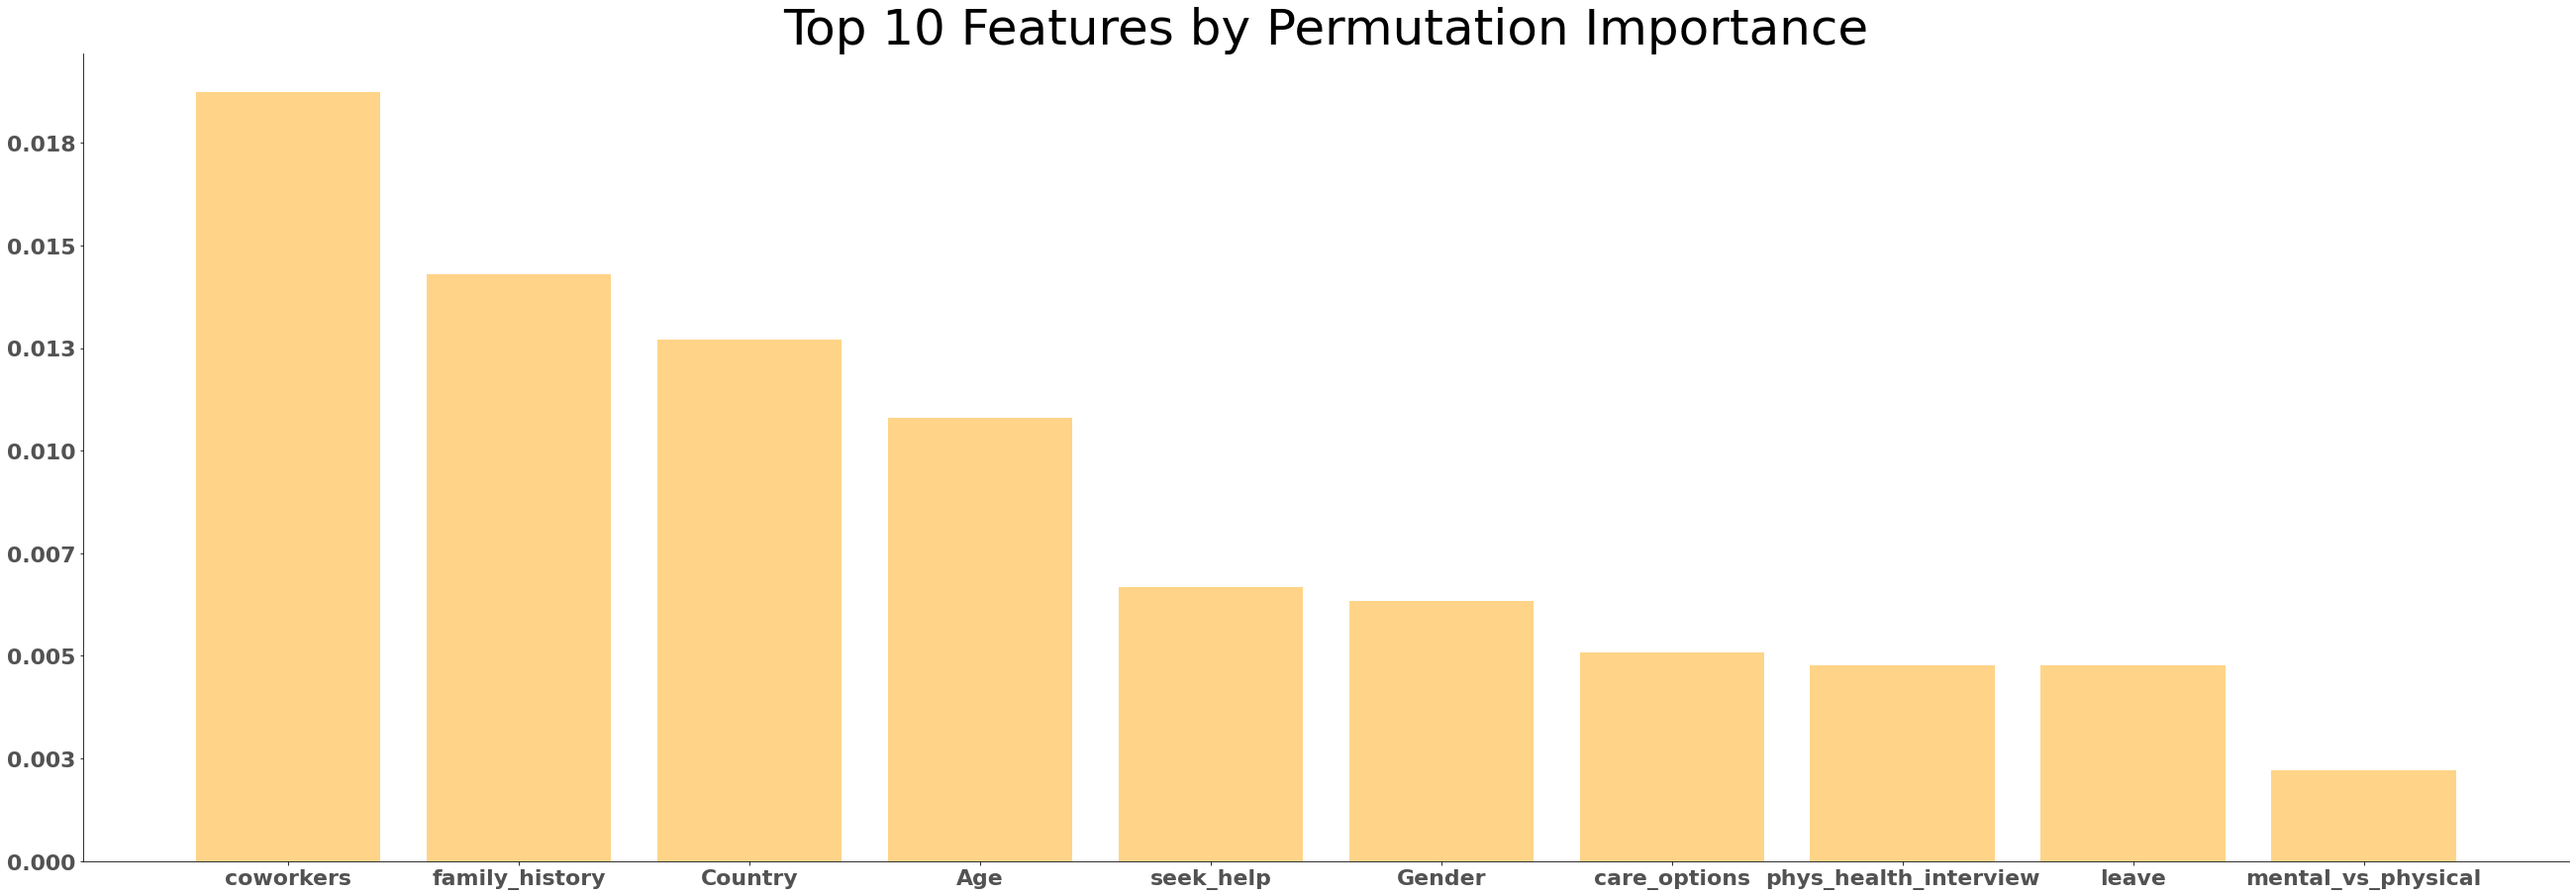

In [167]:
fig, ax = plt.subplots(figsize=(45,15)) 

plt.bar(importances_df['feature'], importances_df['importance'], color='#ffd488')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title("Top 10 Features by Permutation Importance", fontsize=50)
ax.set_xticklabels(importances_df['feature'], fontsize = '22', color = '#525252', fontweight='bold')
ax.set_yticklabels(importances_df['importance'], fontsize = '22', color = '#525252', fontweight = 'bold')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.show()